1. add all HO data together
2. add all lost df together
3. 

In [1375]:
import os
import re
import ast
import copy
import json
import swifter
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import Timestamp
from collections import namedtuple
from datetime import timedelta, datetime

Read previous data

In [1376]:
HO = namedtuple('HO', ['start', 'end', 'others', 'trans'], defaults=[None, None, '', ''])

def ho_encoder(obj):
    if isinstance(obj, datetime):
        return obj.strftime('%Y-%m-%d %H:%M:%S.%f')  # Convert datetime to string
    return obj


In [1377]:
concated_ordered_ho_path = "/Volumes/MOLLY256/MOXA/concated_data/Handover"
concated_loss_file_path = "/Volumes/MOLLY256/MOXA/concated_data/PacketLoss"
concated_file_path = ""

all_ordered_ho_datas = []
all_ho_dict = {'Conn_Rel': [], 'Conn_Req': [], 'LTE_HO': [], 'MN_HO': [], 'MN_HO_to_eNB': [], 'SN_setup': [], 'SN_Rel': [], 'SN_HO': [], 
               'RLF_II': [], 'RLF_III': [], 'SCG_RLF': []}

# with open(f"{concated_ordered_ho_path}/concated_HOs.json", 'r') as f:
#     all_ho_dict = json.load(f)
# # Convert Timestamp strings back to Timestamp objects
# for key, value in all_ho_dict.items():
#     all_ho_dict[key] = [HO(start=pd.to_datetime(ho[0], format='%Y-%m-%d %H:%M:%S.%f'), 
#                            end=pd.to_datetime(ho[1], format='%Y-%m-%d %H:%M:%S.%f') if ho[1] is not None else None, 
#                            others=ho[2],
#                            trans=ho[3]) for ho in value]


# all_ul_loss_df = pd.read_csv(f"{concated_loss_file_path}/concated_ul_loss.csv")
# all_dl_loss_df = pd.read_csv(f"{concated_loss_file_path}/concated_dl_loss.csv")

figure_path = "/Users/molly/Desktop"

event_dict = {'Conn_Rel': 1, 'Conn_Req': 2, 'LTE_HO': 3, 'MN_HO': 4, 'MN_HO_to_eNB': 5, 'SN_setup': 6, 'SN_Rel': 7, 'SN_HO': 8, 'stable': 0, 
              'RLF_II': 9, 'RLF_III': 10, 'SCG_RLF': 11, 'Add_Scell': 12}
colors_dict = {'Conn_Rel': '#ed5555', 'Conn_Req': '#78c4b1', 'LTE_HO': '#3ea357', 'MN_HO': '#e8803a', 
               'MN_HO_to_eNB': '#ad58c4', 'SN_setup': '#ddbfde', 'SN_Rel': '#a1543f', 'SN_HO': '#d4c68a', 'stable': '#878483',
               'RLF_II': '#59a2c2', 'RLF_III': '#6494c4', 'SCG_RLF': '#646fc4'}

In [1378]:
### USER SETTINGS ###
database="/Volumes/mollyT7/MOXA"
# database = "/Volumes/MOLLY256/MOXA/"
# database = "/Users/molly/Desktop"

dates = [
    # "/Users/molly/Desktop/2024-01-26",
    "2024-02-03",
    # "2024-02-17",
]
devices = sorted([
    "sm00",
    "sm01",
])
exps = {
    # "QUIC-300sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    "QUIC-450sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    # "QUIC-280sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
}

device_to_port = {"sm00": [4200, 4201, 5200, 5201], 
                  "sm01": [4202, 4203, 5202, 5203],
                  "sm02": [4204, 4205, 5204, 5205]}

### Get Handover Data

In [1379]:
# FUNCTIONS
def find_rrc_files(database, date, exp, device):
    rrc_files = []
    exp_rounds, exp_list = exps[exp]
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "_rrc.csv" in file:
                    rrc_files.append(os.path.join(root, file))
    return rrc_files

def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    
    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

class REPORTCONFIG:
    def __init__(self, name, parameter):
        self.name = name.split(' ')[0]  
        self.parameters = self.parse_parameter(parameter)
    
    def parse_parameter(self, parameter):
        L = []
        start = False
        for i in range(len(parameter)):
            if parameter[i] == "'" and start == False:
                s = ''
                start = True
                continue
            
            if start:
                if parameter[i] == "'":
                    L.append(s)
                    start = False
                s += parameter[i]
        
        P = dict()
        filter = '+-0123456789[]()&'
        for i in range(0,len(L),2):
            x = ''
            for c in L[i+1]:
                if c in filter:
                    x += c
            try:
                P[L[i]] = int(x)
            except:
                P[L[i]] = x
        return P
    
    def reset_name(self, name):
        self.name = name

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

class MEASOBJ:

    def __init__(self, obj, freq):
        self.name = obj
        self.freq = freq

    def __str__(self):
        return f'({self.name}, {self.freq})'

    def __repr__(self):
        return f'({self.name}, {self.freq})'

def parse_measIdToAddMod(s):
    a = s.replace('(','')
    a = a.replace(')','')
    a = a.split('&')
    return (a[0], a[1], a[2])

def MeasureReport(file):

    mi_rrc_df = pd.read_csv(file)
    mi_rrc_df["Timestamp"] = mi_rrc_df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    unused = ['DL frequency','UL frequency', 'DL bandwidth', 'UL bandwidth', 'Cell Identity', 'TAC','Band ID', 'MCC', 'MNC']
    mi_rrc_df = mi_rrc_df.drop(columns=unused)
    mi_rrc_df = mi_rrc_df.dropna()    
    cols_to_covert = ['measObjectId', 'carrierFreq', 'carrierFreq-r15', 'lte-reportConfigId', 'lte-measIdToRemoveList', 'measId', 'ssbFrequency']
    mi_rrc_df[cols_to_covert] = mi_rrc_df[cols_to_covert].astype('str')

    measobj_dict, report_config_dict, measId_dict = {}, {}, {}
    nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    def reset():

        global measobj_dict, report_config_dict, measId_dict, nr_measobj_dict, nr_report_config_dict, nr_measId_dict  
        measobj_dict, report_config_dict, measId_dict = {}, {}, {}
        nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    L = []

    RRC_connected = True
    Unknown = REPORTCONFIG('Unknown', {})

    for i in range(len(mi_rrc_df)):

        if mi_rrc_df['type_id'].iloc[i] == "5G_NR_RRC_OTA_Packet" or mi_rrc_df['type_id'].iloc[i] == "LTE_RRC_Serv_Cell_Info":
            continue

        time = mi_rrc_df['Timestamp'].iloc[i]
        others = ''
        
        # if mi_rrc_df["rrcConnectionRelease"].iloc[i] == 1:      
        #     reset()

        if mi_rrc_df["lte-measIdToRemoveList"].iloc[i] != '0':

            measIdToRemove_list = mi_rrc_df["lte-measIdToRemoveList"].iloc[i].split('@')
            if len(measIdToRemove_list) == 32:
                measId_dict = {}
            elif len(measId_dict) != 0:
                for a in range(len(measIdToRemove_list)):
                    try: measId_dict.pop(measIdToRemove_list[a])
                    except: pass

        if mi_rrc_df["lte-measurementReport"].iloc[i] == 1:
            
            others += 'E-UTRAN'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = measId_dict[id]
                event = report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)

            L.append(mr)

        if mi_rrc_df["nr-measurementReport"].iloc[i] == 1:
            
            others += 'NR'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = nr_measId_dict[id]
                event = nr_report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)
            
            L.append(mr)

        if mi_rrc_df["lte-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            carrierFreq_list = mi_rrc_df["carrierFreq"].iloc[i].split('@')
            carrierFreq_r15_list = mi_rrc_df["carrierFreq-r15"].iloc[i].split('@')
            
            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectEUTRA (0)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_list[0])
                    carrierFreq_list.pop(0)
                elif measobj_list[a] == "measObjectNR-r15 (5)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_r15_list[0])
                    carrierFreq_r15_list.pop(0)
    

        if mi_rrc_df["nr-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            ssbFrequency_list = mi_rrc_df["ssbFrequency"].iloc[i].split('@')

            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectNR (0)":
                    nr_measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], ssbFrequency_list[0])
                    ssbFrequency_list.pop(0)     

            
        if mi_rrc_df["lte-ReportConfigToAddMod"].iloc[i] == 1:

            reportConfigId_list = mi_rrc_df["lte-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["lte-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["lte-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])


        if mi_rrc_df["nr-ReportConfigToAddMod"].iloc[i] == 1: #############

            reportConfigId_list = mi_rrc_df["nr-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["nr-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["nr-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                nr_report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])

        if mi_rrc_df["lte-MeasIdToAddMod"].iloc[i] != '0':

            MeasIdToAdd_list = mi_rrc_df["lte-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                measId_dict[x[0]] = (x[1],x[2])


        if mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != '0' and mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != 0:

            MeasIdToAdd_list = mi_rrc_df["nr-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                nr_measId_dict[x[0]] = (x[1],x[2])

    # Sort to Dict
    types = ['eventA1','eventA2','E-UTRAN-eventA3', 'eventA5', 'eventA6','NR-eventA3', 'eventB1-NR-r15','reportCGI', 'reportStrongestCells', 'others']
    D = {k: [] for k in types}

    for mr in L:

        if 'E-UTRAN' in mr.others and 'eventA1' in mr.event.name:
            D['eventA1'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA2' in mr.event.name:
            D['eventA2'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventA3' in mr.event.name:
            D['E-UTRAN-eventA3'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA5' in mr.event.name:
            D['eventA5'].append(mr)

        elif 'E-UTRAN' in mr.others and 'eventA6' in mr.event.name:
            D['eventA6'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventB1-NR-r15' in mr.event.name:
            D['eventB1-NR-r15'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportCGI' in mr.event.name:
            D['reportCGI'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportStrongestCells' in mr.event.name:
            D['reportStrongestCells'].append(mr)
        
        elif 'NR' in mr.others and 'eventA3' in mr.event.name:
            D['NR-eventA3'].append(mr)       
        
        else:
            D['others'].append(mr)

    return D

def map_MR_HO(MRs, HOs):

    map_ho_types = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', ]
    map_mr_types = ['E-UTRAN-eventA3', 'eventA5', 'eventB1-NR-r15', 'NR-eventA3']

    D = {'LTE_HO': [], 'NR_HO': [], 'SN_setup': []}

    for lte_ho_type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB']:
        for ho in HOs[lte_ho_type]:
            for mr_type in ['E-UTRAN-eventA3', 'eventA5']:
                
                for mr in MRs[mr_type]:
                    # The current mapping way may map a HO with repeated measurement report.
                    dif = (ho.start - mr.time).total_seconds()
                    if 0 < dif < 0.5:
                        D['LTE_HO'].append((mr, ho, lte_ho_type))

    for nr_ho_type in ['SN_Rel', 'SN_HO']:
        for ho in HOs[nr_ho_type]:
            for mr in MRs['NR-eventA3']:

                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5:
                    D['NR_HO'].append((mr, ho, nr_ho_type))

    for ho in HOs['SN_setup']:
        for mr in MRs['eventB1-NR-r15']:

            dif = (ho.start - mr.time).total_seconds()
            if 0 < dif < 0.5:
                D['SN_setup'].append((mr, ho, 'SN_setup'))

    return D

# Correct MR with HO
def correct_MR_with_HO(MRs, HOs):
    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    new_MRs = copy.deepcopy(MRs)
    del new_MRs['others']

    for mr in MRs['others']:
        if 'E-UTRAN' in mr.others:
            for ho in HOs['LTE_HO'] + HOs['MN_HO']:
                if 0.3 > (ho.start - mr.time).total_seconds() > 0:
                    mr.event.reset_name('eventA3')
                    new_MRs['E-UTRAN-eventA3'].append(MR(time = mr.time, event = mr.event, others = mr.others))
    
        elif 'NR' in mr.others:
            for ho in HOs['SN_HO']:
                if 0.3 > (ho.start - mr.time).total_seconds() > 0:
                    mr.event.reset_name('eventA3')
                    new_MRs['NR-eventA3'].append(MR(time = mr.time, event = mr.event, others = mr.others))
    
    return new_MRs

# For colored output text
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def print_trans(HOs, p=True, mappings=None):

    All_HOs = []
    selected = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', 
    'Conn_Req' ,'RLF_II', 'RLF_III', 'SCG_RLF']

    def find_mr(target, ho):
        for mapping in target:
            map_ho = mapping[1]
            if ho == map_ho:
                mr = mapping[0]
                return mr
        return None

    for type in selected:

        for ho in HOs[type]:

            if type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB'] and mappings is not None:
            
                target = mappings['LTE_HO']
                mr = find_mr(target, ho)
                
                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_Rel', 'SN_HO'] and mappings is not None:
            
                target = mappings['NR_HO']
                mr = find_mr(target, ho)

                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_setup'] and mappings is not None:
            
                target = mappings['SN_setup']
                mr = find_mr(target, ho)

                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])
                
            else:
                All_HOs.append([type, ho])

    All_HOs = sorted(All_HOs, key = lambda x: x[1].start)

    ## THIS CAN PRINT OUT THE HO DATA IN COLOR
    # if p:
    #     for ho in All_HOs:
    #         if len(ho) == 3:
    #             print(f'{ho[1].start} | {bcolors.OKBLUE}{ho[0]}{bcolors.ENDC} | {bcolors.OKCYAN}{ho[1].trans}{bcolors.ENDC} | {bcolors.OKGREEN}{ho[2].event.name}{bcolors.ENDC} | {ho[2].event.parameters}')
    #         elif len(ho) == 2:
    #             print(f'{ho[1].start} | {bcolors.OKBLUE}{ho[0]}{bcolors.ENDC} | {bcolors.OKCYAN}{ho[1].trans}{bcolors.ENDC}')

    return All_HOs


In [1380]:
new_rrc_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            # Find "rrc" files for the current combination of date, exp, and device
            rrc_files = find_rrc_files(database, date, exp, device)
            # Extend the list of all "rrc" files
            new_rrc_files.extend(rrc_files)

In [1381]:
# Read all "rrc" files
all_mappings = {'LTE_HO':[], 'NR_HO':[], 'SN_setup':[]}
rrc_time_pattern = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})"
for file in new_rrc_files:
    # print(file)
    HOs = parse_mi_ho(file)
    for key in all_ho_dict.keys():
        all_ho_dict[key].extend(HOs[key])
    
    MRs = MeasureReport(file)
    MRs = correct_MR_with_HO(MRs, HOs)
    mappings = map_MR_HO(MRs, HOs)
    for key in all_mappings.keys():
        all_mappings[key].extend(mappings[key])
    ordered_HOs = print_trans(HOs, mappings=mappings)
    match = re.search(rrc_time_pattern, os.path.basename(file))
    if match:
        start_time = match.group(1)
        # Convert the timestamp string to a datetime object
        threshold_timestamp = datetime.strptime(start_time, '%Y-%m-%d_%H-%M-%S')
        # Filter entries based on the threshold timestamp
        filtered_entries = [entry for entry in ordered_HOs if entry[1].start > threshold_timestamp]
    
    all_ordered_ho_datas.extend(ordered_HOs)

In [1382]:
# for key, value in all_ho_dict.items():
#     all_ho_dict[key] = [ho._replace(start=str(ho.start), end=str(ho.end) if ho.end is not None else None) for ho in value]

# export HOs as a .json file
# with open(f"{concated_ordered_ho_path}/concated_HOs.json", 'w') as f:
#     json.dump(all_ho_dict, f, default=ho_encoder, indent=4)


### Get Packet Loss Data

In [1383]:
def find_ul_file(database, date, exp, device):
    ul_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[2]) in numbers or str(ports[0]) in numbers:
                        ul_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return ul_files

def find_dl_file(database, date, exp, device):
    dl_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[3]) in numbers or str(ports[1]) in numbers:
                        dl_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return dl_files

def find_ul_loss_file(database, date, exp, device):
    ul_loss_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "ul_real_lost_pk" in file:
                    ul_loss_files.append(os.path.join(root, file))
                    break  # Exit the inner loop once the port is found
    return ul_loss_files

def find_dl_loss_file(database, date, exp, device):
    dl_loss_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "dl_real_lost_pk" in file:
                    dl_loss_files.append(os.path.join(root, file))
                    break  # Exit the inner loop once the port is found
    return dl_loss_files



In [1384]:
all_ul_files = []
all_ul_pkl_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            ul_pk_files = find_ul_file(database, date, exp, device)
            ul_pk_loss_files = find_ul_loss_file(database, date, exp, device)
            all_ul_files.extend(ul_pk_files)
            all_ul_pkl_files.extend(ul_pk_loss_files)

ul_dfs = []
ul_loss_dfs = []
# Iterate over each file path
for file_path in all_ul_files:
    ul_df = pd.read_csv(file_path, sep='@')
    ul_dfs.append(ul_df)
for file_path in all_ul_pkl_files:
    # Read CSV file into a DataFrame and append it to the list
    ul_loss_df = pd.read_csv(file_path)
    ul_loss_dfs.append(ul_loss_df)
# Concatenate all DataFrames into a single DataFrame
all_ul_df = pd.concat(ul_dfs, ignore_index=True)
all_ul_loss_df = pd.concat(ul_loss_dfs, ignore_index=True)

all_ul_real_loss_df = all_ul_loss_df[all_ul_loss_df['lost']==True]
all_ul_excl_df = all_ul_loss_df[all_ul_loss_df['excl']==True]


In [1385]:
all_ul_pkl_files

['/Volumes/mollyT7/MOXA/2024-02-03/QUIC-450sec/sm00/#01/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-02-03/QUIC-450sec/sm00/#02/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-02-03/QUIC-450sec/sm00/#03/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-02-03/QUIC-450sec/sm00/#04/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-02-03/QUIC-450sec/sm00/#05/data/ul_real_lost_pk.csv',
 '/Volumes/mollyT7/MOXA/2024-02-03/QUIC-450sec/sm00/#06/data/ul_real_lost_pk.csv']

In [1386]:
all_dl_files = []
all_dl_pkl_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            dl_pk_files = find_dl_file(database, date, exp, device)
            dl_pk_loss_files = find_dl_loss_file(database, date, exp, device)
            all_dl_files.extend(dl_pk_files)
            all_dl_pkl_files.extend(dl_pk_loss_files)

dl_dfs = []
dl_loss_dfs = []
# Iterate over each file path
for file_path in all_dl_files:
    dl_df = pd.read_csv(file_path, sep='@')
    dl_dfs.append(dl_df)
for file_path in all_dl_pkl_files:
    # Read CSV file into a DataFrame and append it to the list
    dl_loss_df = pd.read_csv(file_path)
    dl_loss_dfs.append(dl_loss_df)
# Concatenate all DataFrames into a single DataFrame
all_dl_df = pd.concat(dl_dfs, ignore_index=True)
all_dl_loss_df = pd.concat(dl_loss_dfs, ignore_index=True)

all_dl_real_loss_df = all_dl_loss_df[all_dl_loss_df['lost']==True]
all_dl_excl_df = all_dl_loss_df[all_dl_loss_df['excl']==True]

In [1387]:
print(len(all_ul_real_loss_df), len(all_dl_real_loss_df))
print(len(all_ul_loss_df), len(all_dl_loss_df))

647 3880
1048 4107


In [1388]:
# all_ul_loss_df.to_csv(f"{concated_loss_file_path}/concated_ul_loss.csv", index=False)
# all_dl_loss_df.to_csv(f"{concated_loss_file_path}/concated_dl_loss.csv", index=False)

### Handover Interval

In [1389]:
all_ul_loss_df['ho_type'] = 0
all_dl_loss_df['ho_type'] = 0
all_ul_real_loss_df['ho_type'] = 0
all_dl_real_loss_df['ho_type'] = 0

/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_78369/3571754206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_ul_real_loss_df['ho_type'] = 0
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_78369/3571754206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dl_real_loss_df['ho_type'] = 0


In [1390]:
def count_records_within_1_second(all_pk_df, loss_latency_df, D, event_dict):
    # Convert timestamp columns to datetime objects
    all_pk_df['timestamp'] = pd.to_datetime(all_pk_df['timestamp'])
    loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])

    # Initialize a dictionary to store the counts for each event type
    event_counts = {}
    event_loss_counts = {}
    # event = {'Event Type': [], 'HO Object': [], 'before': [], 'before_event': [], 'during':[], 'during_event': [], 'after': [], 'after_event': []}
    events_list = []


    # Loop through each event type in D
    for event_type, ho_objects in D.items():
        if event_type == "Add_SCell":
            continue
        event_counts[event_type] = {'before': [], 'during':[], 'after': []}
        event_loss_counts[event_type] = {'before': [], 'during':[], 'after': []}

        # Loop through each HO object in the current event type
        for ho in ho_objects:
            event = {'loss_before': [], 'loss_before_event': [], 'loss_during':[], 'loss_during_event': [], 'loss_after': [], 'loss_after_event': [], 
                     'sent_before': [], 'sent_during': [], 'sent_after': []}
            if ho.end is not None:
                start = pd.to_datetime(ho.start)
                end = pd.to_datetime(ho.end)
                sec_before_start = start - timedelta(seconds=1)
                sec_after_end = end + timedelta(seconds=1)
            else:
                # continue
                start = pd.to_datetime(ho.start)
                end = pd.to_datetime(ho.start)
                sec_before_start = start - timedelta(seconds=1)
                sec_after_end = start + timedelta(seconds=1)
            # print(start_time, ho.start, loss_latency_df['timestamp'])

            # Filter and display the records in loss_latency_df within the specified time range
            relevant_loss_before = loss_latency_df[(start > loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] >= sec_before_start)]
            relevant_loss_after = loss_latency_df[(end < loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= sec_after_end)]
            relevant_loss_during = loss_latency_df[(start <= loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= end)]
            relevant_sent_before = all_pk_df[(start > all_pk_df['timestamp']) & (all_pk_df['timestamp'] >= sec_before_start)]
            relevant_sent_after = all_pk_df[(end < all_pk_df['timestamp']) & (all_pk_df['timestamp'] <= sec_after_end)]
            relevant_sent_during = all_pk_df[(start <= all_pk_df['timestamp']) & (all_pk_df['timestamp'] <= end)]

            for records_df in [relevant_loss_before, relevant_loss_during, relevant_loss_after]:
                records_df.loc[records_df['ho_type'] == 0, 'ho_type'] = event_dict[event_type]

            loss_latency_df.loc[relevant_loss_before.index] = relevant_loss_before
            loss_latency_df.loc[relevant_loss_during.index] = relevant_loss_during
            loss_latency_df.loc[relevant_loss_after.index] = relevant_loss_after

            event_loss_counts[event_type]['before'].append(len(relevant_loss_before))
            event_loss_counts[event_type]['after'].append(len(relevant_loss_after))
            event_loss_counts[event_type]['during'].append(len(relevant_loss_during))
            event_counts[event_type]['before'].append(len(relevant_sent_before))
            event_counts[event_type]['after'].append(len(relevant_sent_after))
            event_counts[event_type]['during'].append(len(relevant_sent_during))

            event['Event Type'] = f"{event_type}"
            event['HO Object'] = f"{ho}"
            event['before'] = len(relevant_loss_before)
            event['before_event'] = relevant_loss_before
            event['during'] = len(relevant_loss_during)
            event['during_event'] = relevant_loss_during
            event['after'] = len(relevant_loss_after)
            event['after_event'] = relevant_loss_after
            event['sent_before'] = len(relevant_sent_before)
            event['sent_during'] = len(relevant_sent_during)
            event['sent_after'] = len(relevant_sent_after)

            events_list.append(event)

    return events_list, event_counts, event_loss_counts, loss_latency_df

def calculate_event_sums_lists(event_counts):
    success_sum_before = {}
    success_sum_during = {}
    success_sum_after = {}
    failure_sum_before = {}
    failure_sum_after = {}
    # Initialize lists to store the sums of before, during, and after counts
    success_sum_before_list = []
    success_sum_during_list = []
    success_sum_after_list = []
    failure_sum_before_list = []
    failure_sum_after_list = []

    # Loop through each event type
    for event_type, counts in event_counts.items():
        # Initialize sums for this event type
        if (event_type == 'RLF_II') or (event_type == 'RLF_III') or (event_type == 'SCG_RLF'):
            failure_sum_before[event_type] = sum(counts['before'])
            failure_sum_after[event_type] = sum(counts['after'])
            failure_sum_before_list.append(sum(counts['before']))
            failure_sum_after_list.append(sum(counts['after']))
            
        elif (event_type != 'Add_SCell'):
            success_sum_before[event_type] = sum(counts['before'])
            success_sum_during[event_type] = sum(counts['during'])
            success_sum_after[event_type] = sum(counts['after'])
            success_sum_before_list.append(sum(counts['before']))
            success_sum_during_list.append(sum(counts['during']))
            success_sum_after_list.append(sum(counts['after']))

    return success_sum_before_list, success_sum_during_list, success_sum_after_list, failure_sum_before_list, failure_sum_after_list, success_sum_before, success_sum_during, success_sum_after, failure_sum_before, failure_sum_after

def plot_event_sums(ul_dl, success_sum_before_list, success_sum_during_list, success_sum_after_list,
                    failure_sum_before_list, failure_sum_after_list):
    x = ['Conn_Rel',
         'Conn_Req',  # Setup
         'LTE_HO',  # LTE -> newLTE
         'MN_HO',  # LTE + NR -> newLTE + NR
         'MN_HO_to_eNB',  # LTE + NR -> newLTE
         'SN_setup',  # LTE -> LTE + NR => NR setup
         'SN_Rel',  # LTE + NR -> LTE
         'SN_HO',  # LTE + NR -> LTE + newNR
         ]

    w = 0.2

    # Create an array of indices for x-axis positioning
    indices = np.arange(len(x))

    # Create a wider figure (e.g., width=10 inches, height=6 inches)
    # plt.figure(figsize=(12, 5))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))  # 2 rows, 1 column of subplots
    ax1.bar(indices, success_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax1.bar(indices + 1.1 * w, success_sum_during_list, color='#6db6ed', width=0.15, label='during event')
    ax1.bar(indices + 1.8 * w, success_sum_after_list, color='#e4a2f2', width=0.15, label='after event')

    # Set custom x-axis labels
    ax1.set_xticks(indices + w)
    ax1.set_xticklabels(x)
    ax1.legend()

    x2 = ['RLF_II',  # fail but reestablishment success
          'RLF_III',  # fail but reestablishment reject
          'SCG_RLF'
          ]

    # Create an array of indices for x-axis positioning
    indices2 = np.arange(len(x2))

    ax2.bar(indices2, failure_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax2.bar(indices2 + 1.6 * w, failure_sum_after_list, color='#e4a2f2', width=0.15, label='after event')

    # Set custom x-axis labels
    ax2.set_xticks(indices2 + 1 * w)
    ax2.set_xticklabels(x2)
    ax2.legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_events_{ul_dl}.png")
    plt.show()

def LossProportion(data, ul_dl):

    filtered_data = {key: value for key, value in data.items() if key != 'stable' and value != 0}
    labels = [key for key, value in filtered_data.items() if value != 0]
    sizes = [value for value in filtered_data.values() if value != 0]
    colors = [colors_dict[key] for key in labels]

    fig, ax = plt.subplots()
    ax.pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Loss Proportion')
    plt.tight_layout(rect=[0, 0, 0.7, 1])
    plt.legend(labels, title="Event Types", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.savefig(f"{figure_path}/pkl_proportion_{ul_dl}.png")
    plt.show()

    # Calculate the sum of values excluding 'stable'
    total_unstable = sum(value for key, value in data.items() if key != 'stable')

    plt.figure(figsize=(5, 5))
    plt.pie([total_unstable, data['stable']], labels=['Unstable', 'Stable'], autopct='%1.1f%%', startangle=90, colors=['#bea6ed', '#99969e'])
    plt.axis('equal')
    plt.title('Stable vs Unstable Proportion')

    # Save/show the plot for stable vs unstable proportion
    plt.tight_layout()
    plt.savefig(f"{figure_path}/brief_proportion_{ul_dl}.png")
    plt.show()

def UlDlStableProportion(ul_loss_df, dl_loss_df):
    # Calculate the sum of values excluding 'stable' for ul_loss_df
    ul_total_unstable = sum(value for key, value in ul_loss_df.items() if key != 'stable')
    ul_stable_value = ul_loss_df.get('stable', 0)

    # Calculate the sum of values excluding 'stable' for dl_loss_df
    dl_total_unstable = sum(value for key, value in dl_loss_df.items() if key != 'stable')
    dl_stable_value = dl_loss_df.get('stable', 0)

    plt.figure(figsize=(8, 4))

    # Plot ul_loss_df
    plt.subplot(1, 2, 1)
    plt.pie([ul_total_unstable, ul_stable_value], autopct='%1.1f%%', startangle=90, colors=['#bea6ed', '#99969e'])
    plt.axis('equal')
    # plt.title('UL Stable vs Unstable Proportion')

    # Plot dl_loss_df
    plt.subplot(1, 2, 2)
    plt.pie([dl_total_unstable, dl_stable_value], autopct='%1.1f%%', startangle=90, colors=['#bea6ed', '#99969e'])
    plt.axis('equal')
    # plt.title('DL Stable vs Unstable Proportion')

    # Add single figure title
    plt.suptitle('Stable vs Unstable Proportion', fontsize=16)

    # Add legend without labels
    plt.legend(['Unstable', 'Stable'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    # Save/show the plot for stable vs unstable proportion
    plt.tight_layout()
    plt.savefig(f"{figure_path}/brief_proportion_ul_dl.png")
    plt.show()

In [1391]:
event_list_ul, event_counts_ul, event_loss_counts_ul, all_ul_loss_df = count_records_within_1_second(all_ul_df, all_ul_loss_df, all_ho_dict, event_dict)
event_list_dl, event_counts_dl, event_loss_counts_dl, all_dl_loss_df = count_records_within_1_second(all_dl_df, all_dl_loss_df, all_ho_dict, event_dict)

In [1392]:
event_list_ul_real, event_counts_ul_real, event_loss_counts_ul_real, all_ul_real_loss_df = count_records_within_1_second(all_ul_df, all_ul_real_loss_df, HOs, event_dict)
event_list_dl_real, event_counts_dl_real, event_loss_counts_dl_real, all_dl_real_loss_df = count_records_within_1_second(all_dl_df, all_dl_real_loss_df, HOs, event_dict)

/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_78369/2170875797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])
/var/folders/ll/z00qrhv13397cv4_52zrrb200000gn/T/ipykernel_78369/2170875797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])


In [1393]:
lost_count_ul = {}
pk_loss_rate_ul = {}
for event_type, counts in event_counts_ul.items():
    loss_count = sum(event_loss_counts_ul[event_type]['before']) + sum(event_loss_counts_ul[event_type]['during']) +sum(event_loss_counts_ul[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    lost_count_ul[event_type] = loss_count
    pk_loss_rate_ul[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, pk_loss_rate_ul[event_type])

Conn_Rel 0 0 0
Conn_Req 0 0 0
LTE_HO 8 1040 0.007692307692307693
MN_HO 367 107273 0.0034211777427684506
MN_HO_to_eNB 52 10684 0.004867090977162112
SN_setup 100 20081 0.004979831681689159
SN_Rel 16 1218 0.013136288998357963
SN_HO 194 106163 0.0018273786535798725
RLF_II 134 6775 0.01977859778597786
RLF_III 0 0 0
SCG_RLF 0 0 0


In [1394]:
real_lost_count_ul = {}
real_pk_loss_rate_ul = {}
for event_type, counts in event_counts_ul_real.items():
    loss_count = sum(event_loss_counts_ul_real[event_type]['before']) + sum(event_loss_counts_ul_real[event_type]['during']) +sum(event_loss_counts_ul_real[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    real_lost_count_ul[event_type] = loss_count
    real_pk_loss_rate_ul[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, real_pk_loss_rate_ul[event_type])

Conn_Rel 0 0 0
Conn_Req 0 0 0
LTE_HO 0 0 0
MN_HO 52 17046 0.003050569048457116
MN_HO_to_eNB 3 663 0.004524886877828055
SN_setup 22 1929 0.011404872991187144
SN_Rel 0 0 0
SN_HO 5 15653 0.0003194275857663068
RLF_II 14 1652 0.00847457627118644
RLF_III 0 0 0
SCG_RLF 0 0 0


In [1395]:
lost_count_dl = {}
pk_loss_rate_dl = {}
for event_type, counts in event_counts_dl.items():
    loss_count = sum(event_loss_counts_dl[event_type]['before']) + sum(event_loss_counts_dl[event_type]['during']) +sum(event_loss_counts_dl[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    lost_count_dl[event_type] = loss_count
    pk_loss_rate_dl[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, pk_loss_rate_dl[event_type])

Conn_Rel 0 0 0
Conn_Req 0 0 0
LTE_HO 31 1488 0.020833333333333332
MN_HO 2836 162471 0.01745542281391756
MN_HO_to_eNB 338 15880 0.02128463476070529
SN_setup 1284 31555 0.040690857233401996
SN_Rel 133 1992 0.06676706827309237
SN_HO 632 157063 0.004023863035851855
RLF_II 1326 10924 0.12138410838520688
RLF_III 0 0 0
SCG_RLF 0 0 0


In [1396]:
real_lost_count_dl = {}
real_pk_loss_rate_dl = {}
for event_type, counts in event_counts_dl.items():
    loss_count = sum(event_loss_counts_dl_real[event_type]['before']) + sum(event_loss_counts_dl_real[event_type]['during']) +sum(event_loss_counts_dl_real[event_type]['after'])
    sent_count = sum(counts['before']) +  sum(counts['during']) + sum(counts['after'])
    real_lost_count_dl[event_type] = loss_count
    real_pk_loss_rate_dl[event_type] = loss_count / sent_count if sent_count != 0 else 0
    print(event_type, loss_count, sent_count, real_pk_loss_rate_dl[event_type])

Conn_Rel 0 0 0
Conn_Req 0 0 0
LTE_HO 0 1488 0.0
MN_HO 774 162471 0.004763927100836457
MN_HO_to_eNB 144 15880 0.00906801007556675
SN_setup 338 31555 0.010711456187608936
SN_Rel 0 1992 0.0
SN_HO 211 157063 0.0013434099692480087
RLF_II 338 10924 0.030941047235444892
RLF_III 0 0 0
SCG_RLF 0 0 0


In [1397]:
print(lost_count_ul)
print(lost_count_dl)
print(pk_loss_rate_ul)
print(pk_loss_rate_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 8, 'MN_HO': 367, 'MN_HO_to_eNB': 52, 'SN_setup': 100, 'SN_Rel': 16, 'SN_HO': 194, 'RLF_II': 134, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 31, 'MN_HO': 2836, 'MN_HO_to_eNB': 338, 'SN_setup': 1284, 'SN_Rel': 133, 'SN_HO': 632, 'RLF_II': 1326, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0.007692307692307693, 'MN_HO': 0.0034211777427684506, 'MN_HO_to_eNB': 0.004867090977162112, 'SN_setup': 0.004979831681689159, 'SN_Rel': 0.013136288998357963, 'SN_HO': 0.0018273786535798725, 'RLF_II': 0.01977859778597786, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0.020833333333333332, 'MN_HO': 0.01745542281391756, 'MN_HO_to_eNB': 0.02128463476070529, 'SN_setup': 0.040690857233401996, 'SN_Rel': 0.06676706827309237, 'SN_HO': 0.004023863035851855, 'RLF_II': 0.12138410838520688, 'RLF_III': 0, 'SCG_RLF': 0}


In [1398]:
print(real_lost_count_ul)
print(real_lost_count_dl)
print(real_pk_loss_rate_ul)
print(real_pk_loss_rate_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 52, 'MN_HO_to_eNB': 3, 'SN_setup': 22, 'SN_Rel': 0, 'SN_HO': 5, 'RLF_II': 14, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 774, 'MN_HO_to_eNB': 144, 'SN_setup': 338, 'SN_Rel': 0, 'SN_HO': 211, 'RLF_II': 338, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 0.003050569048457116, 'MN_HO_to_eNB': 0.004524886877828055, 'SN_setup': 0.011404872991187144, 'SN_Rel': 0, 'SN_HO': 0.0003194275857663068, 'RLF_II': 0.00847457627118644, 'RLF_III': 0, 'SCG_RLF': 0}
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0.0, 'MN_HO': 0.004763927100836457, 'MN_HO_to_eNB': 0.00906801007556675, 'SN_setup': 0.010711456187608936, 'SN_Rel': 0.0, 'SN_HO': 0.0013434099692480087, 'RLF_II': 0.030941047235444892, 'RLF_III': 0, 'SCG_RLF': 0}


Loss Proportion

In [1399]:
# Calculated by "REAL" lost
success_ho_lost_sum_ul = len(all_ul_real_loss_df[(all_ul_real_loss_df['ho_type'] >= 1) & (all_ul_real_loss_df['ho_type'] <= 8)])
failure_ho_lost_sum_ul = len(all_ul_real_loss_df[(all_ul_real_loss_df['ho_type'] >= 9) & (all_ul_real_loss_df['ho_type'] <= 11)])
ho_lost_sum_ul = success_ho_lost_sum_ul + failure_ho_lost_sum_ul
ho_lost_ratio_ul = -1 if len(all_ul_real_loss_df) == 0 else ho_lost_sum_ul / len(all_ul_real_loss_df)

success_ho_lost_sum_dl = len(all_dl_real_loss_df[(all_dl_real_loss_df['ho_type'] >= 1) & (all_dl_real_loss_df['ho_type'] <= 8)])
failure_ho_lost_sum_dl = len(all_dl_real_loss_df[(all_dl_real_loss_df['ho_type'] >= 9) & (all_dl_real_loss_df['ho_type'] <= 11)])
ho_lost_sum_dl = success_ho_lost_sum_dl + failure_ho_lost_sum_dl
ho_lost_ratio_dl = -1 if len(all_dl_real_loss_df) == 0 else ho_lost_sum_dl / len(all_dl_real_loss_df)

print(ho_lost_ratio_ul, ho_lost_ratio_dl)

0.09119010819165378 0.22731958762886598


In [1400]:
all_pkl_sum_ul = {}
success_pkl_sum_ul = {}
failure_pkl_sum_ul = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_pkl_sum_ul[event_type] = len(all_ul_loss_df[all_ul_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_pkl_sum_ul[event_type] = len(all_ul_loss_df[all_ul_loss_df['ho_type'] == ho_type])

all_pkl_sum_ul = {**success_pkl_sum_ul, **failure_pkl_sum_ul}
all_pkl_sum_ul['stable'] = len(all_ul_loss_df[all_ul_loss_df['ho_type'] == 0])

print(success_pkl_sum_ul)
print(failure_pkl_sum_ul)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 8, 'MN_HO': 343, 'MN_HO_to_eNB': 45, 'SN_setup': 17, 'SN_Rel': 14, 'SN_HO': 117}
{'RLF_II': 74, 'RLF_III': 0, 'SCG_RLF': 0}


In [1401]:
all_pkl_sum_dl = {}
success_pkl_sum_dl = {}
failure_pkl_sum_dl = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_pkl_sum_dl[event_type] = len(all_dl_loss_df[all_dl_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_pkl_sum_dl[event_type] = len(all_dl_loss_df[all_dl_loss_df['ho_type'] == ho_type])

all_pkl_sum_dl = {**success_pkl_sum_dl, **failure_pkl_sum_dl}
all_pkl_sum_dl['stable'] = len(all_dl_loss_df[all_dl_loss_df['ho_type'] == 0])

print(success_pkl_sum_dl)
print(failure_pkl_sum_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 31, 'MN_HO': 2467, 'MN_HO_to_eNB': 282, 'SN_setup': 968, 'SN_Rel': 132, 'SN_HO': 20}
{'RLF_II': 150, 'RLF_III': 0, 'SCG_RLF': 0}


In [1402]:
all_real_pkl_sum_ul = {}
success_real_pkl_sum_ul = {}
failure_real_pkl_sum_ul = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_real_pkl_sum_ul[event_type] = len(all_ul_real_loss_df[all_ul_real_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_real_pkl_sum_ul[event_type] = len(all_ul_real_loss_df[all_ul_real_loss_df['ho_type'] == ho_type])

all_real_pkl_sum_ul = {**success_real_pkl_sum_ul, **failure_real_pkl_sum_ul}
all_real_pkl_sum_ul['stable'] = len(all_ul_real_loss_df[all_ul_real_loss_df['ho_type'] == 0])

print(len(all_ul_real_loss_df), success_ho_lost_sum_ul, failure_ho_lost_sum_ul)
print(success_real_pkl_sum_ul)
print(failure_real_pkl_sum_ul)

647 59 0
{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 52, 'MN_HO_to_eNB': 3, 'SN_setup': 1, 'SN_Rel': 0, 'SN_HO': 3}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


In [1403]:
all_real_pkl_sum_dl = {}
success_real_pkl_sum_dl = {}
failure_real_pkl_sum_dl = {}

for event_type, ho_type in event_dict.items():
    # Calculate the sum for each event type
    if ho_type in range(1, 9):
        success_real_pkl_sum_dl[event_type] = len(all_dl_real_loss_df[all_dl_real_loss_df['ho_type'] == ho_type])
    if ho_type in range(9, 12):
        failure_real_pkl_sum_dl[event_type] = len(all_dl_real_loss_df[all_dl_real_loss_df['ho_type'] == ho_type])

all_real_pkl_sum_dl = {**success_real_pkl_sum_dl, **failure_real_pkl_sum_dl}
all_real_pkl_sum_dl['stable'] = len(all_dl_real_loss_df[all_dl_real_loss_df['ho_type'] == 0])

print(success_real_pkl_sum_dl)
print(failure_real_pkl_sum_dl)

{'Conn_Rel': 0, 'Conn_Req': 0, 'LTE_HO': 0, 'MN_HO': 651, 'MN_HO_to_eNB': 144, 'SN_setup': 73, 'SN_Rel': 0, 'SN_HO': 14}
{'RLF_II': 0, 'RLF_III': 0, 'SCG_RLF': 0}


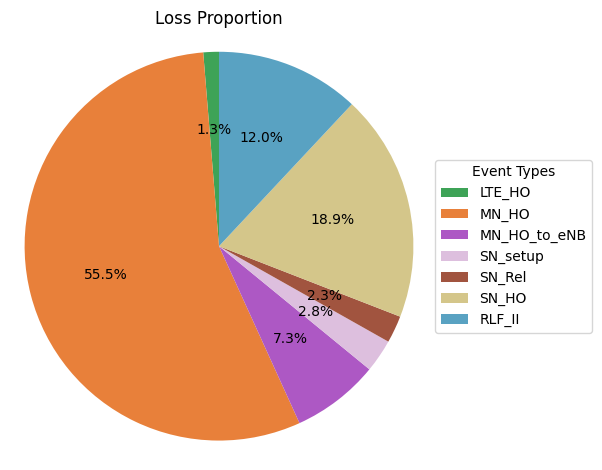

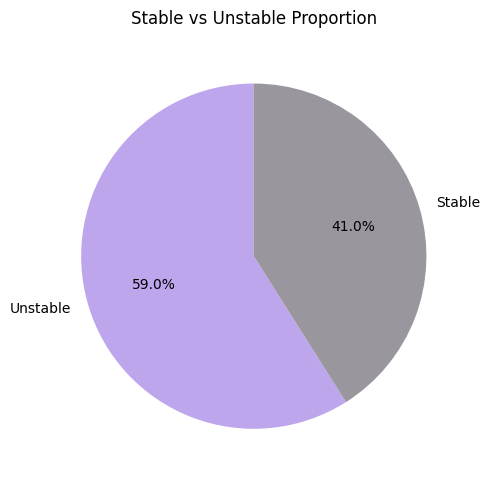

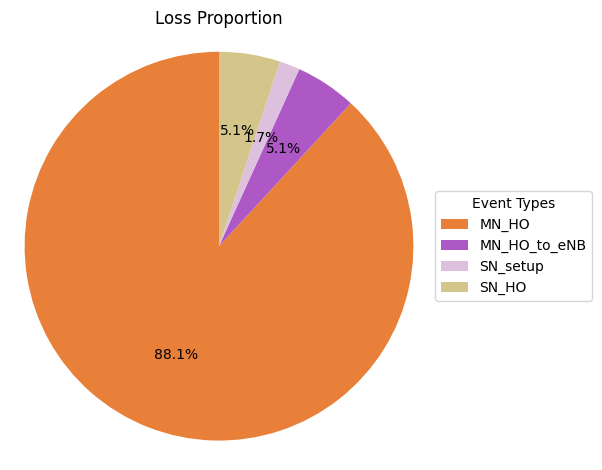

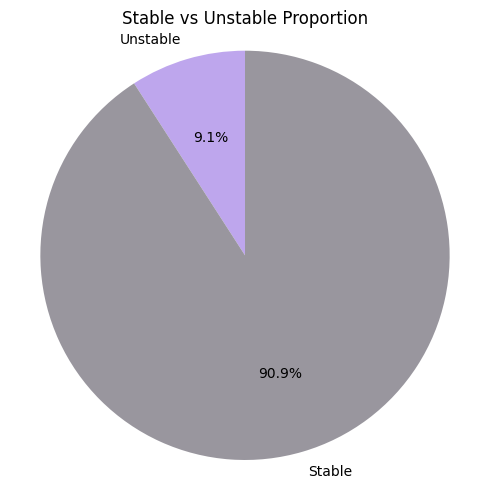

In [1404]:
LossProportion(all_pkl_sum_ul, "ul")
LossProportion(all_real_pkl_sum_ul, "ul_adjusted")

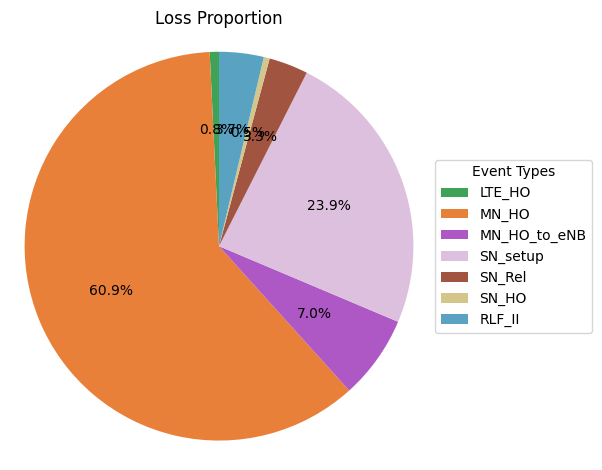

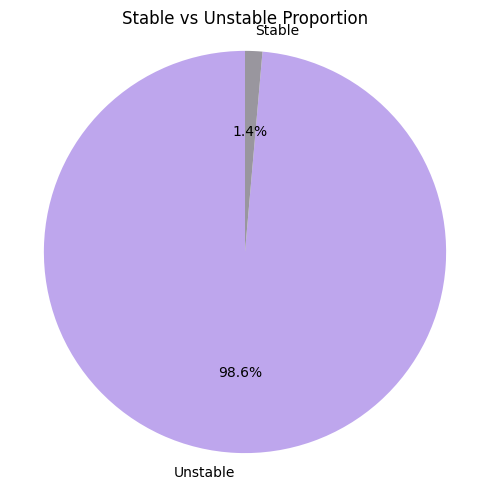

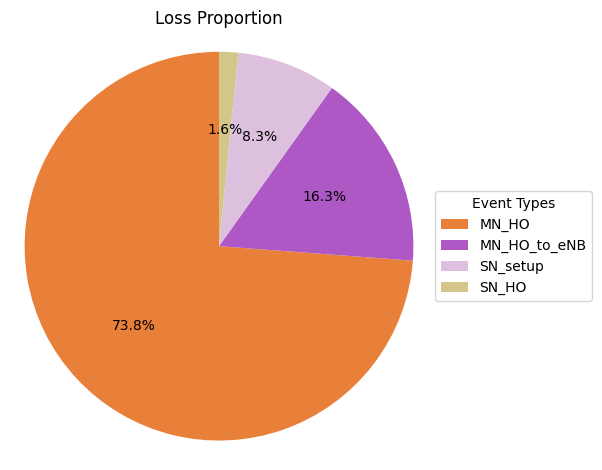

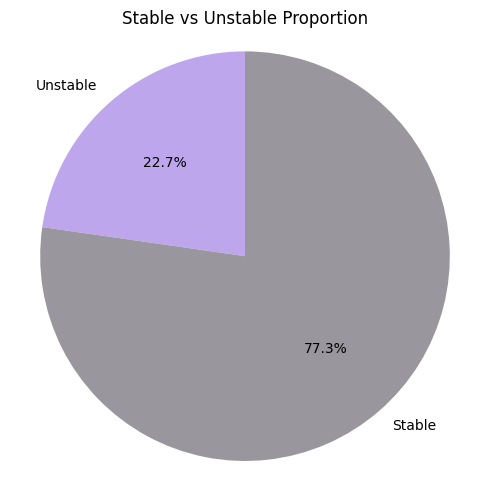

In [1405]:
LossProportion(all_pkl_sum_dl, "dl")
LossProportion(all_real_pkl_sum_dl, "dl_adjusted")

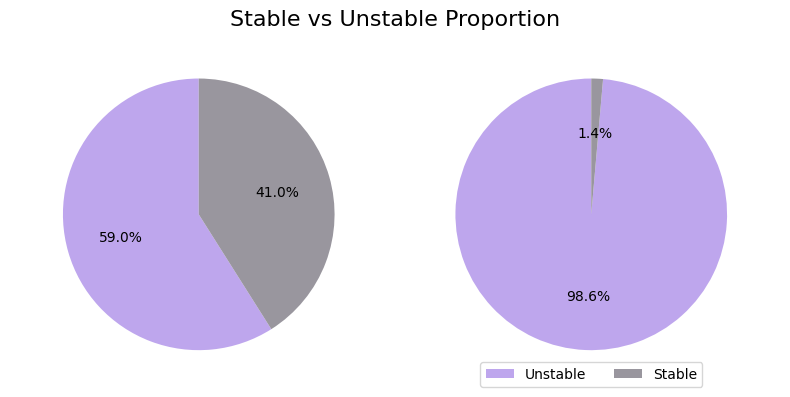

In [1406]:
UlDlStableProportion(all_pkl_sum_ul, all_pkl_sum_dl)

In [1407]:
def LossExclProportion(all_loss_df, all_real_loss_df, all_excl_df, ul_dl):
    # Calculate lengths of all_real_loss_df and all_excl_df
    real_loss_length = len(all_real_loss_df)
    excl_length = len(all_excl_df)

    # Calculate proportions
    total_length = len(all_loss_df)
    real_loss_proportion = real_loss_length / total_length
    excl_proportion = excl_length / total_length

    # Plot the pie chart
    sizes = [real_loss_proportion, excl_proportion]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # explode the 1st slice (Real Loss)
    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proportion of Real Loss & Threshhold Exceeded')
    plt.legend(['Real Loss', 'Threshhold Exceeded'], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)
    plt.savefig(f"{figure_path}/real_pkl_proportion_{ul_dl}.png")
    plt.show()

def TimeReorderExclProportion(all_excl_df, all_time_excl_df, all_reorder_excl_df,  ul_dl):
    total_excl_length = len(all_excl_df)
    time_excl_length = len(all_time_excl_df)
    reorder_excl_length = len(all_reorder_excl_df)
    time_excl_proportion = time_excl_length / total_excl_length
    reorder_excl_proportion = reorder_excl_length / total_excl_length

    sizes = [time_excl_proportion, reorder_excl_proportion]
    colors = ['#e08dca', '#e08d9b']
    explode = (0.1, 0)  # explode the 1st slice (Real Loss)
    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proportion of Threshhold Exceeded')
    plt.legend(['Time Threshold', 'Reorder Threshhold'], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)
    plt.savefig(f"{figure_path}/threshold_excl_proportion_{ul_dl}.png")
    plt.show()


In [1408]:
all_ul_time_df = all_ul_loss_df[all_ul_loss_df['trigger']=="time_threshold"]
all_ul_reorder_df = all_ul_loss_df[all_ul_loss_df['trigger']=="reordering_threshold"]
all_ul_time_excl_df = all_ul_excl_df[all_ul_excl_df['trigger']=="time_threshold"]
all_ul_reorder_excl_df = all_ul_excl_df[all_ul_excl_df['trigger']=="reordering_threshold"]
all_dl_time_df = all_dl_loss_df[all_dl_loss_df['trigger']=="time_threshold"]
all_dl_reorder_df = all_dl_loss_df[all_dl_loss_df['trigger']=="reordering_threshold"]
all_dl_time_excl_df = all_dl_excl_df[all_dl_excl_df['trigger']=="time_threshold"]
all_dl_reorder_excl_df = all_dl_excl_df[all_dl_excl_df['trigger']=="reordering_threshold"]

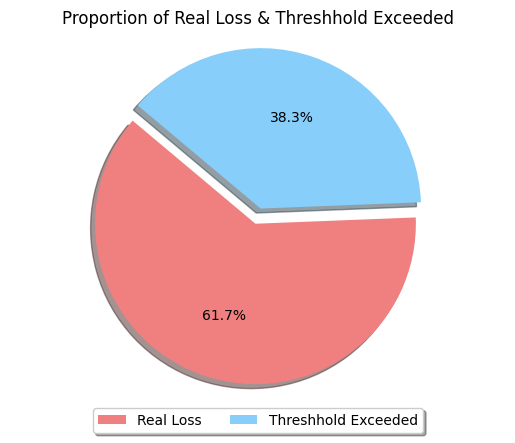

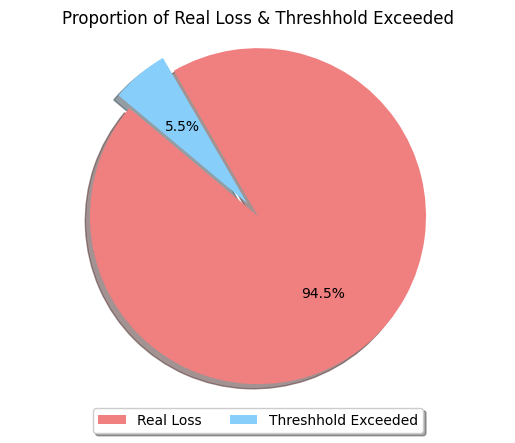

In [1409]:
LossExclProportion(all_ul_loss_df, all_ul_real_loss_df, all_ul_excl_df, "ul")
LossExclProportion(all_dl_loss_df, all_dl_real_loss_df, all_dl_excl_df, "dl")

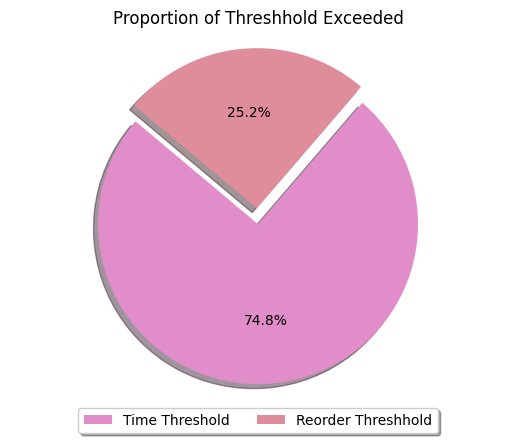

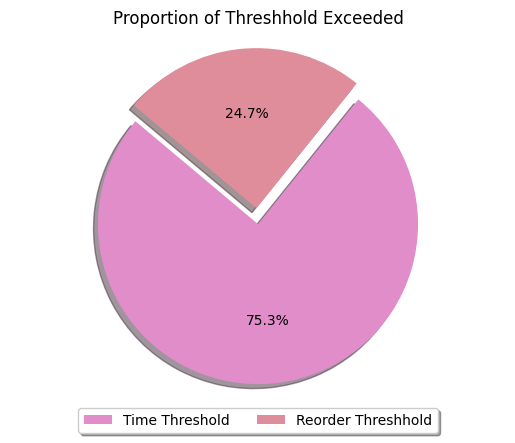

In [1410]:
TimeReorderExclProportion(all_ul_excl_df, all_ul_time_excl_df, all_ul_reorder_excl_df, "ul")
TimeReorderExclProportion(all_dl_excl_df, all_dl_time_excl_df, all_dl_reorder_excl_df, "dl")

In [1411]:
def ThresholdProportion(all_loss_df, all_time_df, all_reorder_df, all_time_excl_df, all_reorder_excl_df, ul_dl):
    # Calculate proportions for all_loss_df
    total_length = len(all_loss_df)
    time_proportion = len(all_time_df) * 100 / total_length
    reorder_proportion = len(all_reorder_df) * 100 / total_length

    # Calculate proportions for all_time_excl_df and all_reorder_excl_df
    time_excl_proportion = len(all_time_excl_df) * 100 / len(all_time_df)
    reorder_excl_proportion = len(all_reorder_excl_df) * 100 / len(all_reorder_df)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot bar chart for all_loss_df
    labels_all = ['Time Threshold', 'Reordering Threshold']
    proportions_all = [time_proportion, reorder_proportion]
    colors_all = ['lightblue', 'lightgreen']

    axes[0].bar(labels_all, proportions_all, color=colors_all)
    axes[0].set_title('Proportion of Thresholds')
    # axes[0].set_xlabel('Threshold Type')
    axes[0].set_ylabel('Proportion(%)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].yaxis.set_major_locator(ticker.MultipleLocator(10))  # Set y-axis intervals to 10

    # Plot bar chart for all_excl_df
    labels_excl = ['Time Exceeded', 'Reordering Exceeded']
    proportions_excl = [time_excl_proportion, reorder_excl_proportion]
    colors_excl = ['lightcoral', 'lightsalmon']

    axes[1].bar(labels_excl, proportions_excl, color=colors_excl)
    axes[1].set_title('Proportion of Thresholds Exceeded')
    # axes[1].set_xlabel('Threshold Type')
    axes[1].set_ylabel('Proportion(%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].yaxis.set_major_locator(ticker.MultipleLocator(10))  # Set y-axis intervals to 10

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"{figure_path}/threshold_{ul_dl}.png")
    plt.show()

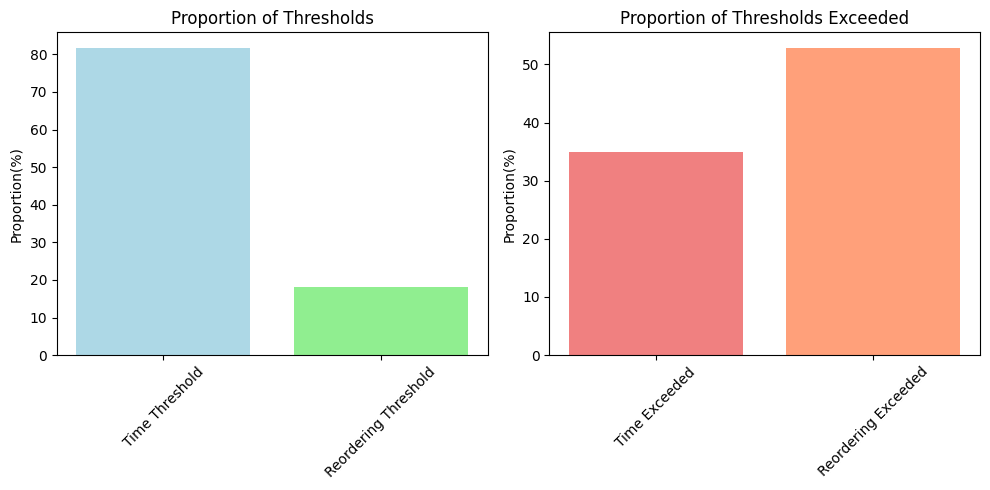

In [1412]:
ThresholdProportion(all_ul_loss_df, all_ul_time_df, all_ul_reorder_df, all_ul_time_excl_df, all_ul_reorder_excl_df, "ul")

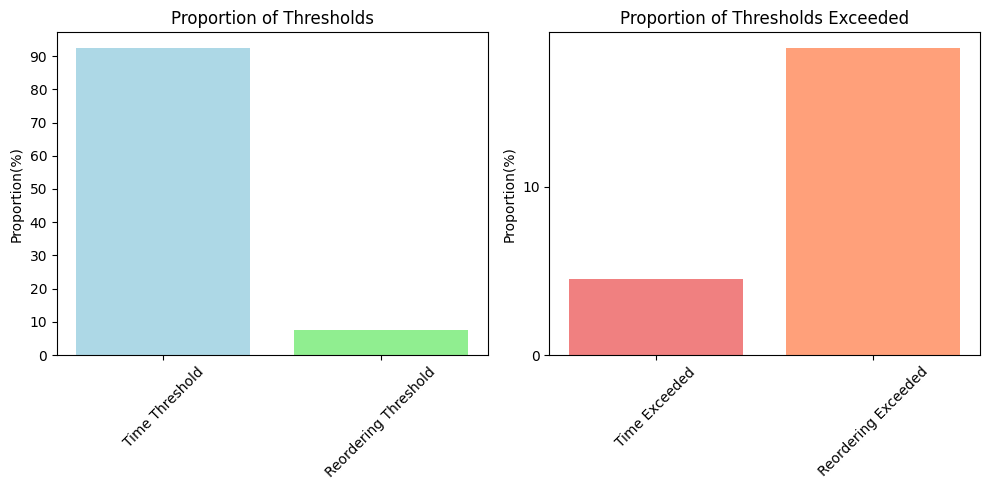

In [1413]:
ThresholdProportion(all_dl_loss_df, all_dl_time_df, all_dl_reorder_df, all_dl_time_excl_df, all_dl_reorder_excl_df, "dl")

Calulate the occurrence of every event

In [1414]:
def PlotHoFreq(all_ho_count):
    # Sort the data by values in descending order
    sorted_data = dict(sorted(all_ho_count.items(), key=lambda item: item[1], reverse=True))
    print(sorted_data)
    # Extract keys and values
    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    # Plot the data with colors
    plt.figure(figsize=(12, 6))
    plt.bar(keys, values, color=[colors_dict[key] for key in keys])
    plt.xlabel('Event Type')
    plt.ylabel('Frequency')
    plt.title('Frequency of Event Occurrence')
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_frequency.png")
    plt.show()

# HO count and the average packet loss per event
def PlotHoPkl(all_ho_count, success_pkl_sum, failure_pkl_sum, ul_dl):
    # Sort the data by keys
    sorted_data = dict(sorted(all_ho_count.items(), key=lambda item: item[1], reverse=True))
    # Extract keys and values
    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    # plot the handover bar chart with colors
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bars = ax1.bar(keys, values, color=[colors_dict[key] for key in keys])

    # Plot the line chart
    ax2 = ax1.twinx()
    x = list(range(len(keys)))
    # Cmbine success and failure ho
    pkl_sum = {**success_pkl_sum, **failure_pkl_sum}
    y = [pkl_sum[key] for key in keys]
    line = ax2.plot(x, y, marker='o', color='black', label='Frequency')

    # make 0 at the bottom
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)

    # Set labels and titles
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Handover Frequency', color='black')
    ax2.set_ylabel('Total Packet Loss', color='black')
    ax1.set_title('Frequency of Event Occurrence')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/event_frequency_{ul_dl}.png")
    plt.show()

# Packet loss per event & page loss rate
def PlotPklPlr(all_ho_count, success_pkl_sum, failure_pkl_sum, page_loss_rate, ul_dl):
    # Exclude keys and concat data
    exclude_keys = ['stable']
    success_pkl_sum_mod = {k: v for k, v in success_pkl_sum.items() if k not in exclude_keys}
    pkl_sum = {**success_pkl_sum_mod, **failure_pkl_sum}
   
    # Calculate pkl_per_event values
    pkl_per_event_values = {}
    for key in pkl_sum.keys():
        if all_ho_count[key] != 0:
            pkl_per_event_values[key] = (pkl_sum[key] / all_ho_count[key])
        else:
            pkl_per_event_values[key] = 0  # Assign 0 if denominator is zero
    # Sort the data by keys
    sorted_pkl_sum = dict(sorted(pkl_per_event_values.items(), key=lambda item: item[1], reverse=True))
    # Extract keys and values
    keys = list(sorted_pkl_sum.keys())
    

    # Plot the handover bar chart with colors
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bars = ax1.bar(keys, list(sorted_pkl_sum.values()), color=[colors_dict[key] for key in keys])

    # Plot the line chart
    ax2 = ax1.twinx()
    x = list(range(len(keys)))
    y = [page_loss_rate[key] for key in keys]
    line = ax2.plot(x, y, marker='o', color='black', label='PLR')

    # Make 0 at the bottom
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)

    # Set labels and titles
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Packet Loss per Event', color='black')
    ax2.set_ylabel('Packet Loss Rate', color='black')
    ax1.set_title('Packet Loss and Packet Loss Rate')
    ax2.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/pkl_plr_{ul_dl}.png")
    plt.show()

def PlotHoPlr(all_ho_count, page_loss_rate, ul_dl):
    sorted_page_loss_rate = dict(sorted(page_loss_rate.items(), key=lambda item: item[1], reverse=True))
    sorted_event_types = list(sorted_page_loss_rate.keys())
    loss_rates = list(rate * 100 for rate in sorted_page_loss_rate.values())
    event_counts = [all_ho_count[event_type] for event_type in sorted_event_types]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # Plot bar chart for all_ho_count
    bars = ax1.bar(sorted_event_types, event_counts, color=[colors_dict[key] for key in sorted_event_types], label='Event Count')

    # Create secondary axis for line chart
    ax2 = ax1.twinx()

    # Plot line chart for page_loss_rate
    line = ax2.plot(sorted_event_types, loss_rates, color='black', marker='o', label='Packet Loss Rate')
    
    # Make 0 at the bottom
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    # Set labels and title
    ax1.set_xlabel('Event Type')
    ax1.set_ylabel('Event Count', color='black')
    ax2.set_ylabel('Packet Loss Rate(%)', color='black')
    plt.title('Event Count and Packet Loss Rate')
    plt.xticks(rotation=45)
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{figure_path}/ho_plr_{ul_dl}.png")
    plt.show()

In [1415]:
## Calulate the occurrence of every event
all_ho_count = {key: len(value) for key, value in all_ho_dict.items()}

# Print the lengths dictionary
print(all_ho_count)

{'Conn_Rel': 6, 'Conn_Req': 8, 'LTE_HO': 2, 'MN_HO': 170, 'MN_HO_to_eNB': 18, 'SN_setup': 41, 'SN_Rel': 2, 'SN_HO': 168, 'RLF_II': 15, 'RLF_III': 0, 'SCG_RLF': 0}


{'MN_HO': 170, 'SN_HO': 168, 'SN_setup': 41, 'MN_HO_to_eNB': 18, 'RLF_II': 15, 'Conn_Req': 8, 'Conn_Rel': 6, 'LTE_HO': 2, 'SN_Rel': 2, 'RLF_III': 0, 'SCG_RLF': 0}


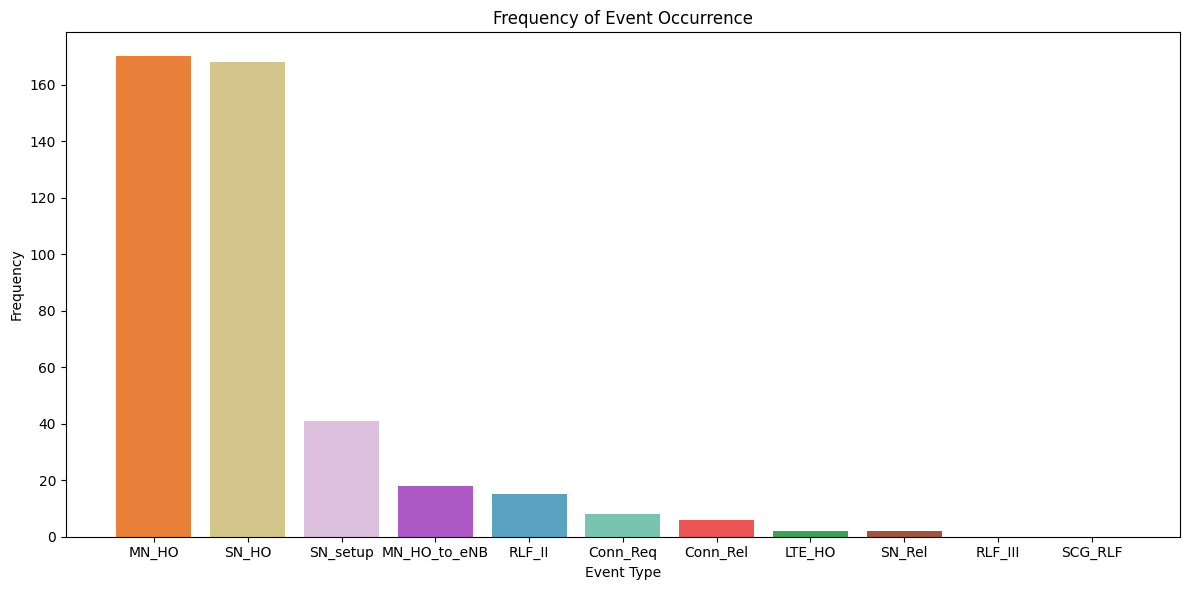

In [1416]:
PlotHoFreq(all_ho_count)

In [1417]:
# PlotHoPkl(all_ho_count, success_pkl_sum_ul, failure_pkl_sum_ul, "ul")

In [1418]:
# PlotHoPkl(all_ho_count, success_pkl_sum_dl, failure_pkl_sum_dl, "dl")

In [1419]:
# PlotPklPlr(all_ho_count, success_pkl_sum_ul, failure_pkl_sum_ul, page_loss_rate_ul, "ul")

In [1420]:
# PlotPklPlr(all_ho_count, success_pkl_sum_dl, failure_pkl_sum_dl, page_loss_rate_dl, "dl")

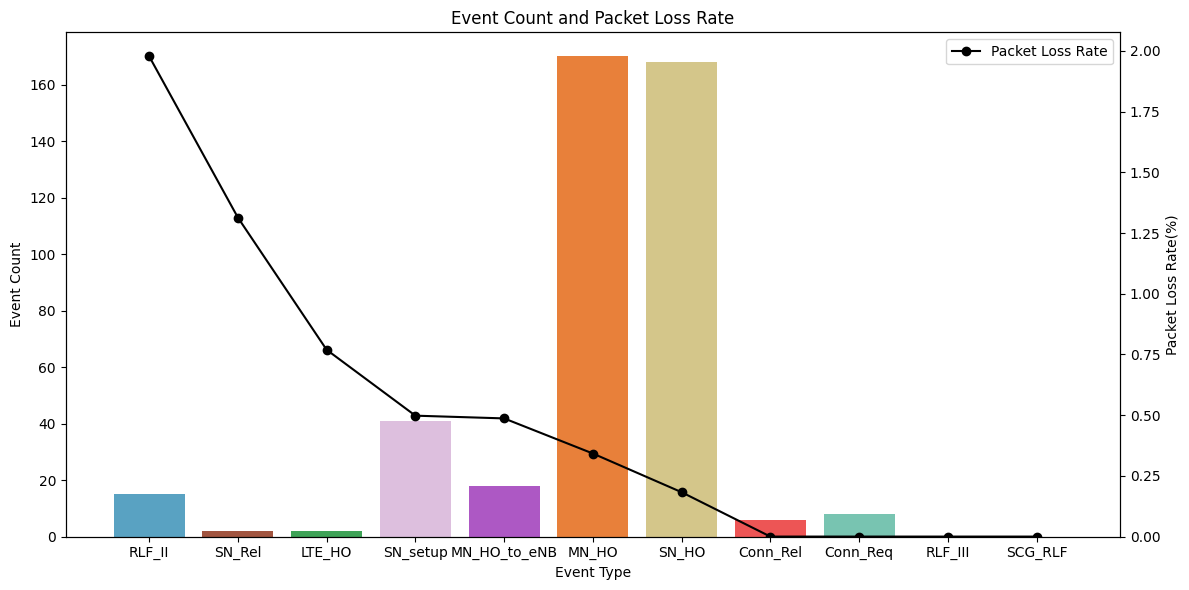

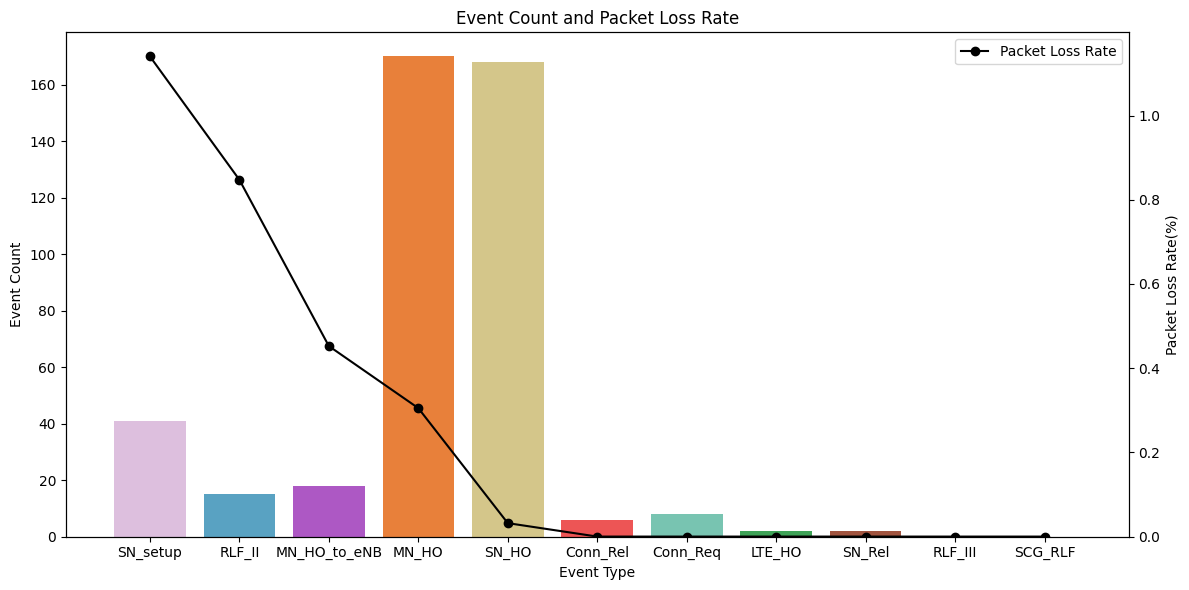

In [1421]:
PlotHoPlr(all_ho_count, pk_loss_rate_ul, "ul")
PlotHoPlr(all_ho_count, real_pk_loss_rate_ul, "ul_adjusted")

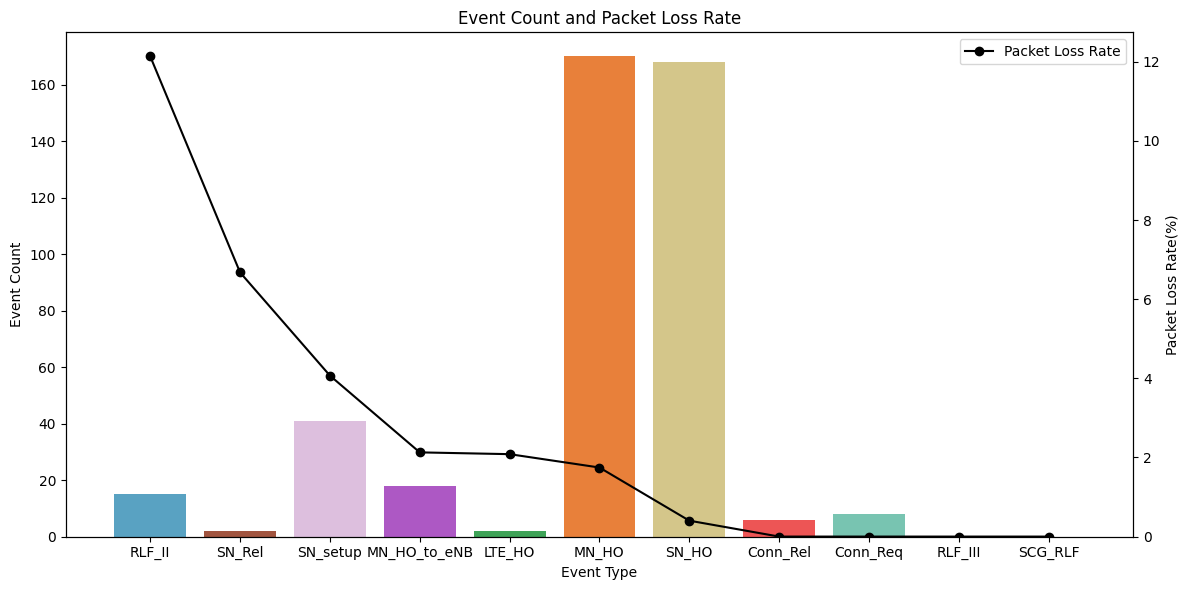

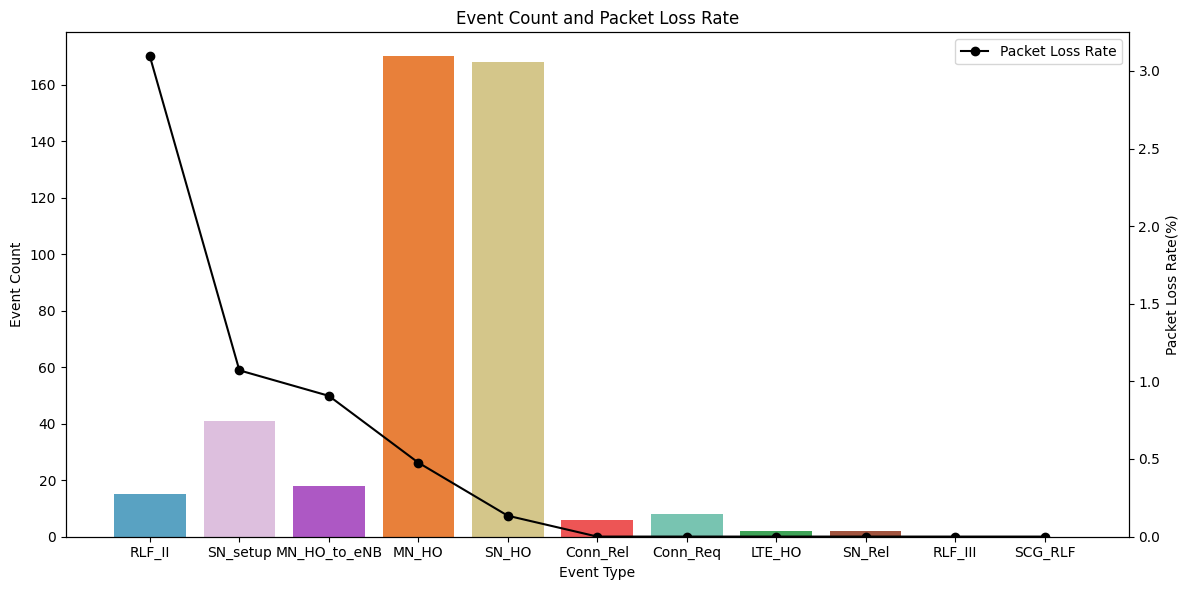

In [1422]:
PlotHoPlr(all_ho_count, pk_loss_rate_dl, "dl")
PlotHoPlr(all_ho_count, real_pk_loss_rate_dl, "dl_adjusted")

## Retransmission

In [1423]:
def find_ul_file(database, date, exp, device):
    ul_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[2]) in numbers:
                        ul_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return ul_files

def find_dl_file(database, date, exp, device):
    dl_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[3]) in numbers:
                        dl_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return dl_files

In [1424]:
all_ul_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            ul_pk_files = find_ul_file(database, date, exp, device)
            all_ul_files.extend(ul_pk_files)

dfs = []
df_lens = []
# Iterate over each file path
for file_path in all_ul_files:
    # Read CSV file into a DataFrame and append it to the list
    df = pd.read_csv(file_path, sep='@')
    dfs.append(df)
# Concatenate all DataFrames into a single DataFrame
all_ul_df = pd.concat(dfs, ignore_index=True)

ValueError: No objects to concatenate

In [ ]:
all_dl_files = []
# Iterate over dates, exps, and devices
for date in dates:
    for exp in exps:
        for device in devices:
            dl_pk_files = find_dl_file(database, date, exp, device)
            all_dl_files.extend(dl_pk_files)

dfs = []
# Iterate over each file path
for file_path in all_dl_files:
    # Read CSV file into a DataFrame and append it to the list
    df = pd.read_csv(file_path, sep='@')
    dfs.append(df)
# Concatenate all DataFrames into a single DataFrame
all_dl_df = pd.concat(dfs, ignore_index=True)

In [ ]:
all_dl_length = all_dl_df['length'].sum()
print("DL Total length:", all_dl_length)

all_ul_length = all_ul_df['length'].sum()
print("UL Total length:", all_ul_length)

DL Total length: 420606750
UL Total length: 420840500
